<a href="https://colab.research.google.com/github/semmatoninn/CHE1148_MOFs_AtomicWizards/blob/main/MOFs_E3GNN__AtomicWizards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHE1148 Direct Air Capture of CO using MOFs
## Rija Ansari, Uyen (Emma) Hua, Miguel Freyermuth
### GNN model on OPENDAC2025

## Package Installation

Before we begin lets install the proper packages we will need for GNN

1. Select T4 GPU
2. Comment in 4 install cells below
3. Once installed restart runtime and run the import cell

In [37]:
#!pip uninstall -y torch torchvision torchaudio
#!pip install torch==2.2.2 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 -q

# Ensure numpy is compatible with PyTorch by installing a specific version
!pip install numpy==1.26.4 -q

In [9]:
!pip install -q torch_scatter torch_sparse torch_cluster torch_spline_conv \
-f https://data.pyg.org/whl/torch-2.2.2+cu121.html

!pip install -q torch_geometric

Looking in links: https://data.pyg.org/whl/torch-2.2.2+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 946.2/946.2 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.4 MB/s eta 0:00:00


In [10]:
import torch
import torch_geometric

print(torch.__version__)
print(torch.version.cuda)
print("PyG installed successfully!")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

2.2.2+cu121
12.1
PyG installed successfully!


In [11]:
!pip install -q ase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 42.7 MB/s eta 0:00:00


## Load and Convert Data

In [1]:
#once installed restart runtime

import torch
import torch_geometric
import torch_scatter
import torch_sparse
import torch_cluster
import ase

print("Everything installed correctly!")

Everything installed correctly!


In [2]:
!git clone https://github.com/semmatoninn/CHE1148_MOFs_AtomicWizards/

fatal: destination path 'CHE1148_MOFs_AtomicWizards' already exists and is not an empty directory.


In [3]:
!ls

CHE1148_MOFs_AtomicWizards  sample_data


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import glob
from ase.io import read
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph, GCNConv, global_mean_pool
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader



from sklearn.model_selection import train_test_split


In [5]:
print(os.listdir('CHE1148_MOFs_AtomicWizards/'))

['MOFs_E3GNN__AtomicWizards.ipynb', 'mof_cif_194.zip', 'README.md', 'mof_cif_194', '.git', 'CO2_labels_per_MOF.csv']


### Unzip MOF CIF Files

In [6]:
!unzip -q CHE1148_MOFs_AtomicWizards/mof_cif_194.zip -d CHE1148_MOFs_AtomicWizards/

replace CHE1148_MOFs_AtomicWizards/mof_cif_194/VEGMOK_charged.cif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


### Load CO2 Labels from CSV

In [7]:
#read the CO2 labels .csv file
df = pd.read_csv('CHE1148_MOFs_AtomicWizards/CO2_labels_per_MOF.csv')
df

,mof_name,mof_type,nco2_max,eads_min,eads_mean,n_configs
0,ADOBEB_charged,pristine,1,-0.146386,-0.030648,699
1,AJAKON,pristine,1,-0.218210,-0.088205,717
2,ANUGEW_deen_33,functionalized,1,-0.272465,0.020770,253
3,AQUCOG_0.11_0_deen_11,functionalized,1,-0.240284,-0.164271,449
4,AQUCOG_0.11_0_dmen_5.5,functionalized,1,-0.151717,-0.075495,286
...,...,...,...,...,...,...
189,ja506357n_si_002_0.12_0,defective,1,-0.323977,-0.188934,866
190,ja5b02897_si_003_0.08_0_en_12,functionalized,1,0.557638,0.664121,668
191,jz4002345_si_002,pristine,1,-0.261281,-0.187379,268
192,jz4002345_si_002_0.08_0,defective,1,-0.240357,-0.169550,508


### Convert CIFs to Graph Data with Labels

Iterate each CIF file to obtain the atomic structure using ASE.

The atomic structure can then be converted to a 'torch_geometric.data.Data'
object.
- nodes represent atoms
- edges represent bonds

The CO2 labels from the CSV file can be added for each unique MOF graph.


In [26]:
def cif_to_graph_data(cif_path, df_labels, cutoff=3.0):
    try:
        # a. Read the CIF file using ase.io.read()
        atoms = read(cif_path)

        # b. Extract atomic numbers, positions, and other relevant features for node features
        x = torch.tensor(atoms.get_atomic_numbers(), dtype=torch.long).unsqueeze(1) # Node features (atomic number)
        pos = torch.tensor(atoms.get_positions(), dtype=torch.float) # Atomic positions

        # c. Determine connectivity between atoms to create edges for the graph
        # Using radius_graph to create edges based on a cutoff distance
        edge_index = radius_graph(pos, r=cutoff, loop=False)

        # d. Create a torch_geometric.data.Data object
        data = Data(x=x, edge_index=edge_index, pos=pos)

        # e. Extract the MOF name from the CIF file path
        mof_filename = os.path.basename(cif_path)
        mof_name_stem = os.path.splitext(mof_filename)[0]

        # Add mof_name_stem as an attribute to the Data object
        data.mof_name = mof_name_stem

        # f. Look up the corresponding CO2 labels ('eads_min', 'eads_mean')
        label_row = df_labels[df_labels['mof_name'] == mof_name_stem]

        if not label_row.empty:
            eads_min = label_row['eads_min'].iloc[0]
            eads_mean = label_row['eads_mean'].iloc[0]
            # g. Attach these labels as attributes to the torch_geometric.data.Data object
            data.y = torch.tensor([eads_min, eads_mean], dtype=torch.float).unsqueeze(0)
        else:
            # Handle cases where labels are not found (e.g., skip or assign default)
            # For now, print a warning and return None
            print(f"Warning: Labels not found for MOF: {mof_name_stem}")
            return None

        # h. Return the Data object
        return data

    except Exception as e:
        print(f"Error processing {cif_path}: {e}")
        return None

In [27]:
cif_directory = 'CHE1148_MOFs_AtomicWizards/mof_cif_194/'
cif_files = glob.glob(os.path.join(cif_directory, '*.cif'))

graph_data_list = []

for cif_file in cif_files:
    graph_data = cif_to_graph_data(cif_file, df)
    if graph_data is not None:
        graph_data_list.append(graph_data)

print(f"Total number of graph objects created: {len(graph_data_list)}")

print("\nFirst 3 generated Data objects:")
for i, data_obj in enumerate(graph_data_list[:3]):
    print(f"\nData Object {i+1}:")
    print(f"  MOF Name: {data_obj.mof_name}") # Added to show the new attribute
    print(f"  Number of nodes (atoms): {data_obj.num_nodes}")
    print(f"  Number of edges (bonds): {data_obj.num_edges}")
    print(f"  Node features (x.shape): {data_obj.x.shape}")
    print(f"  Edge index (edge_index.shape): {data_obj.edge_index.shape}")
    print(f"  Positions (pos.shape): {data_obj.pos.shape}")
    print(f"  Labels (y): {data_obj.y}")

Total number of graph objects created: 194

First 3 generated Data objects:

Data Object 1:
  MOF Name: XEHSIN_0.01_0
  Number of nodes (atoms): 325
  Number of edges (bonds): 1722
  Node features (x.shape): torch.Size([325, 1])
  Edge index (edge_index.shape): torch.Size([2, 1722])
  Positions (pos.shape): torch.Size([325, 3])
  Labels (y): tensor([[-0.3374, -0.2216]])

Data Object 2:
  MOF Name: YIWBEN_0.12_0
  Number of nodes (atoms): 185
  Number of edges (bonds): 1290
  Node features (x.shape): torch.Size([185, 1])
  Edge index (edge_index.shape): torch.Size([2, 1290])
  Positions (pos.shape): torch.Size([185, 3])
  Labels (y): tensor([[0.0131, 0.0949]])

Data Object 3:
  MOF Name: ja5b02897_si_003_0.08_0_en_12
  Number of nodes (atoms): 246
  Number of edges (bonds): 1580
  Node features (x.shape): torch.Size([246, 1])
  Edge index (edge_index.shape): torch.Size([2, 1580])
  Positions (pos.shape): torch.Size([246, 3])
  Labels (y): tensor([[0.5576, 0.6641]])


## Data Split



Before we split our graph data, lets ensure that there are no empty or invalid values

In [28]:
print('--- Starting Data Cleaning Checks for graph_data_list ---')

# Initialize counters for issues found
issues_found = False
empty_graphs_count = 0
missing_labels_count = 0
invalid_node_features_count = 0
invalid_positions_count = 0

for i, data_obj in enumerate(graph_data_list):
    # Check for empty graphs (no nodes or no edges)
    if data_obj.num_nodes == 0 or data_obj.num_edges == 0:
        print(f"Warning: Graph {i} has 0 nodes or 0 edges. Nodes: {data_obj.num_nodes}, Edges: {data_obj.num_edges}")
        empty_graphs_count += 1
        issues_found = True

    # Check if labels (y) exist and have the expected shape/type
    if not hasattr(data_obj, 'y') or data_obj.y is None or data_obj.y.shape != torch.Size([1, 2]):
        print(f"Warning: Graph {i} has invalid or missing labels (y). Shape: {data_obj.y.shape if hasattr(data_obj, 'y') and data_obj.y is not None else 'None'}")
        missing_labels_count += 1
        issues_found = True
    elif torch.isnan(data_obj.y).any() or torch.isinf(data_obj.y).any():
        print(f"Warning: Graph {i} has NaN or Inf values in labels (y).")
        missing_labels_count += 1
        issues_found = True

    # Check node features (x) for valid atomic numbers (positive integers)
    if not hasattr(data_obj, 'x') or data_obj.x is None or data_obj.x.dtype != torch.long or (data_obj.x < 1).any():
        print(f"Warning: Graph {i} has invalid node features (x). Type: {data_obj.x.dtype if hasattr(data_obj, 'x') and data_obj.x is not None else 'None'}, Min value: {data_obj.x.min() if hasattr(data_obj, 'x') and data_obj.x is not None and data_obj.num_nodes > 0 else 'N/A'}")
        invalid_node_features_count += 1
        issues_found = True

    # Check positions (pos) for NaN or Inf values
    if hasattr(data_obj, 'pos') and data_obj.pos is not None:
        if torch.isnan(data_obj.pos).any() or torch.isinf(data_obj.pos).any():
            print(f"Warning: Graph {i} has NaN or Inf values in positions (pos).")
            invalid_positions_count += 1
            issues_found = True
    else:
        print(f"Warning: Graph {i} is missing positions (pos).")
        invalid_positions_count += 1
        issues_found = True


if not issues_found:
    print("No major data cleaning issues detected. All graphs appear to have valid structures and labels.")
else:
    print("--- Data Cleaning Summary: ---")
    print(f"Graphs with 0 nodes or 0 edges: {empty_graphs_count}")
    print(f"Graphs with invalid or missing labels: {missing_labels_count}")
    print(f"Graphs with invalid node features: {invalid_node_features_count}")
    print(f"Graphs with invalid or missing positions: {invalid_positions_count}")

print('--- Finished Data Cleaning Checks ---')


--- Starting Data Cleaning Checks for graph_data_list ---
No major data cleaning issues detected. All graphs appear to have valid structures and labels.
--- Finished Data Cleaning Checks ---


In [29]:
# 70% train, 15% val, 15% test
random_seed = 1148
total_size = len(graph_data_list)
temp_train_val, test_dataset = train_test_split(graph_data_list, test_size=(30/total_size), random_state=random_seed)

# Then, split the training+validation set into training and validation sets
train_dataset, val_dataset = train_test_split(temp_train_val, test_size=(29/len(temp_train_val)), random_state=random_seed)

print(f"Total number of graphs: {total_size}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total number of graphs: 194
Training set size: 135
Validation set size: 29
Test set size: 30


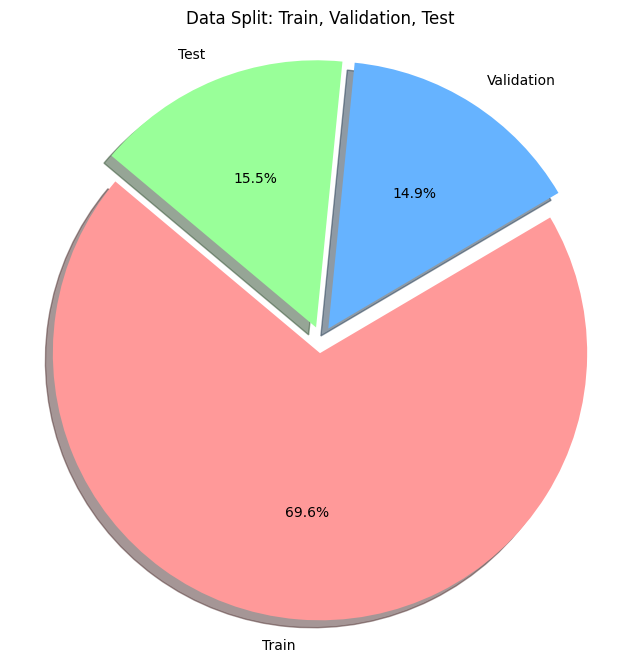

In [30]:
labels = ['Train', 'Validation', 'Test']
sizes = [len(train_dataset), len(val_dataset), len(test_dataset)]
colors = ['#ff9999','#66b3ff','#99ff99']
explode = (0.05, 0.05, 0.05)  # Explode a slice if desired

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Data Split: Train, Validation, Test')
plt.show()

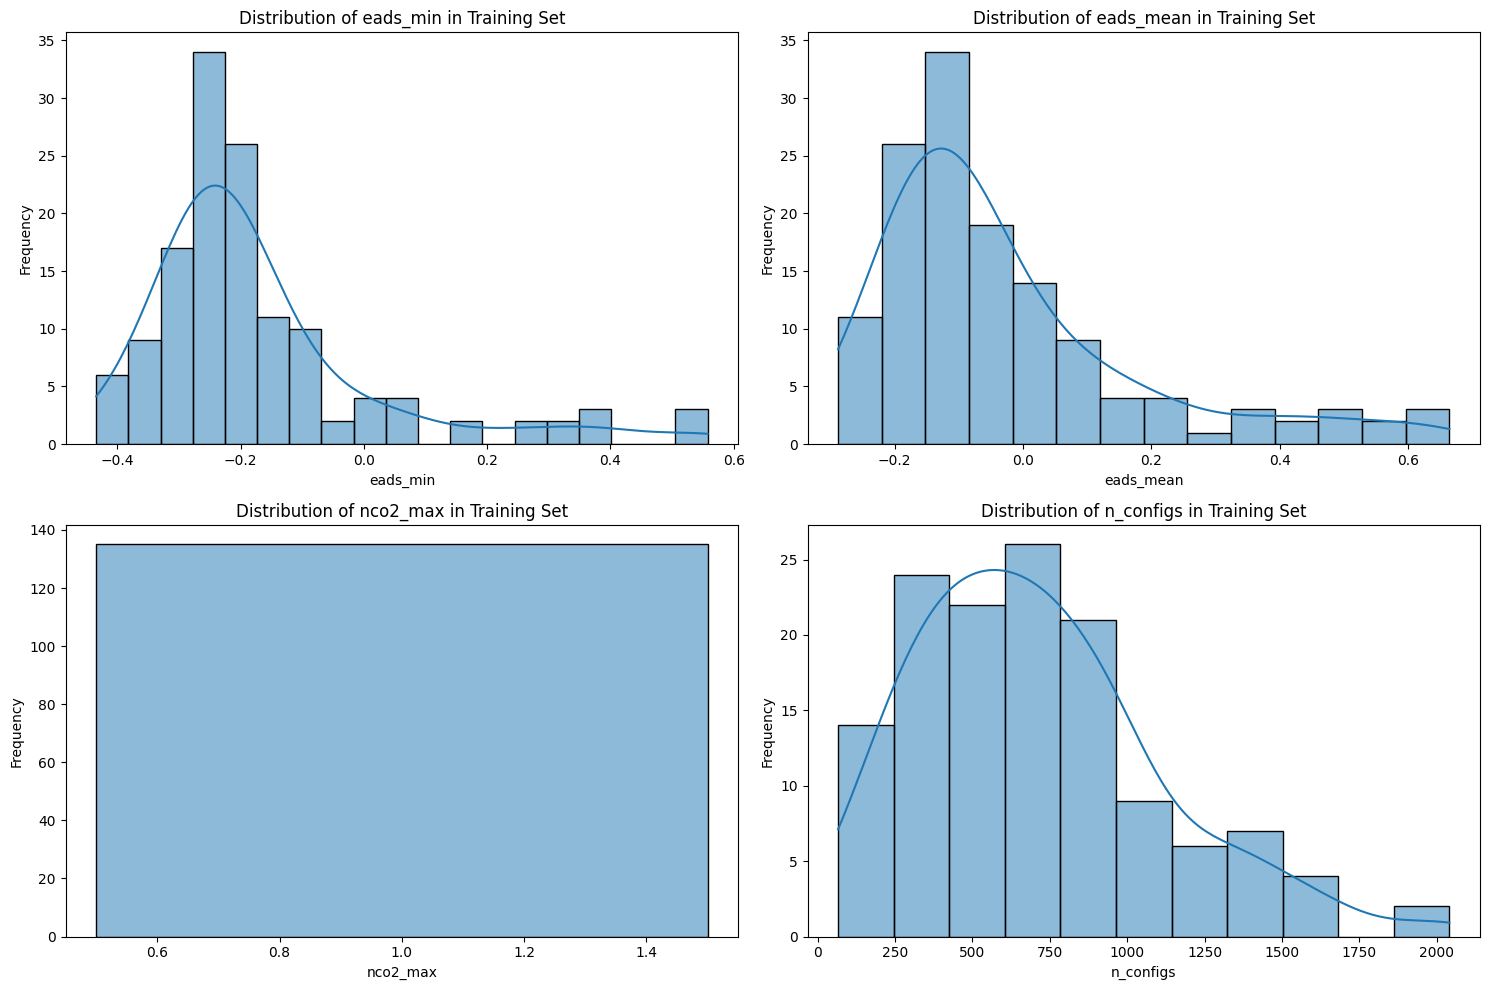

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extract mof_names from the training dataset
train_mof_names = [data.mof_name for data in train_dataset]

# Filter the original dataframe (df) to get labels for the training set
df_train_labels = df[df['mof_name'].isin(train_mof_names)].copy()

# Ensure the order matches if needed, though not strictly necessary for histograms
# For visualization purposes, we are interested in the distribution of these values

# Define the numerical columns to plot
numerical_cols_to_plot = ['eads_min', 'eads_mean', 'nco2_max', 'n_configs']

plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols_to_plot):
    plt.subplot(2, 2, i + 1) # 2 rows, 2 columns
    sns.histplot(df_train_labels[col], kde=True)
    plt.title(f'Distribution of {col} in Training Set')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## Graph Neural Network (GNN) Architecture

- Design a GNN model using `torch_geometric`
  - This will involve defining layers such as `GCNConv`, `GraphSAGEConv`, or others, along with appropriate activation functions and readout layers for regression.
  - The model should be able to process node features (atomic numbers) and edge indices, and output a prediction for `eads_min` and `eads_mean`.


In [32]:
#define GNN model
class GNNModel(nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GNNModel, self).__init__()

        # Embedding layer for atomic numbers
        # Max atomic number could be around 118 for known elements. Add 1 for safety.
        self.embedding = nn.Embedding(num_embeddings=120, embedding_dim=num_node_features)

        # Graph convolutional layers
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        # Linear layers for regression output (2 values: eads_min, eads_mean)
        self.lin1 = nn.Linear(hidden_channels, hidden_channels // 2)
        self.lin2 = nn.Linear(hidden_channels // 2, 2) # Output 2 values

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Convert atomic numbers to float for embedding lookup
        x = x.squeeze(-1) # Remove the last dimension if it's 1, as nn.Embedding expects 1D input for indices
        x = self.embedding(x) # Apply embedding

        # Pass through graph convolutional layers with ReLU activation
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # Global mean pooling to get graph-level representation
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # Pass through linear layers with ReLU activation
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)

        return x

In [33]:
#initialize, loss function and optimizer
num_node_features = 64 # Dimension for node embeddings
hidden_channels = 128 # Hidden channels in GCNConv layers

model = GNNModel(num_node_features=num_node_features, hidden_channels=hidden_channels)
loss_fn = nn.MSELoss() # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



### Training and Evaluation


In [34]:
def train(model, optimizer, loss_fn, data_loader):
    model.train() # Set model to training mode
    total_loss = 0
    for data in data_loader:
        optimizer.zero_grad() # Zero gradients
        out = model(data) # Perform forward pass
        loss = loss_fn(out, data.y) # Calculate loss
        loss.backward() # Perform backward pass
        optimizer.step() # Update model parameters
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(data_loader.dataset)

def evaluate(model, loss_fn, data_loader):
    model.eval() # Set model to evaluation mode
    total_loss = 0
    with torch.no_grad(): # Disable gradient calculations
        for data in data_loader:
            out = model(data) # Perform forward pass
            loss = loss_fn(out, data.y) # Calculate loss
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(data_loader.dataset)


In [35]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [36]:
epochs = 100 # Define the number of epochs

train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = train(model, optimizer, loss_fn, train_loader)
    val_loss = evaluate(model, loss_fn, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Final evaluation on the test set
test_loss = evaluate(model, loss_fn, test_loader)
print(f'\nTest Loss: {test_loss:.4f}')

Epoch: 001, Train Loss: 0.0442, Val Loss: 0.0460
Epoch: 002, Train Loss: 0.0410, Val Loss: 0.0450
Epoch: 003, Train Loss: 0.0400, Val Loss: 0.0474
Epoch: 004, Train Loss: 0.0390, Val Loss: 0.0469
Epoch: 005, Train Loss: 0.0387, Val Loss: 0.0499
Epoch: 006, Train Loss: 0.0384, Val Loss: 0.0508
Epoch: 007, Train Loss: 0.0380, Val Loss: 0.0493
Epoch: 008, Train Loss: 0.0373, Val Loss: 0.0510
Epoch: 009, Train Loss: 0.0372, Val Loss: 0.0500
Epoch: 010, Train Loss: 0.0376, Val Loss: 0.0497
Epoch: 011, Train Loss: 0.0361, Val Loss: 0.0545
Epoch: 012, Train Loss: 0.0359, Val Loss: 0.0514
Epoch: 013, Train Loss: 0.0368, Val Loss: 0.0533
Epoch: 014, Train Loss: 0.0349, Val Loss: 0.0538
Epoch: 015, Train Loss: 0.0345, Val Loss: 0.0537
Epoch: 016, Train Loss: 0.0340, Val Loss: 0.0596
Epoch: 017, Train Loss: 0.0331, Val Loss: 0.0620
Epoch: 018, Train Loss: 0.0350, Val Loss: 0.0663
Epoch: 019, Train Loss: 0.0353, Val Loss: 0.0583
Epoch: 020, Train Loss: 0.0336, Val Loss: 0.0564
Epoch: 021, Train Lo

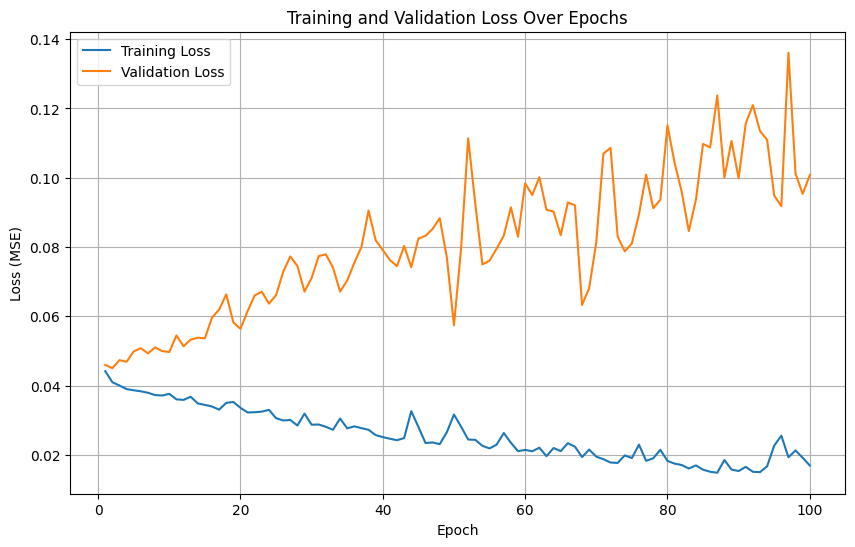

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

To improve the baseline GNN model, we will implement the following:

* Early Stopping: stops the model if validation loss stops improving for a certain number of epochs, preventing further overfitting

* Regularization: use dropout layers within the GNN model or L2 regularization to the optimizer to penalize large weights and reduce complexity

* Hyperparameter Tuning: tune hyperparameters like the learning rate, number of hidden channels, or the number of GCN layers. Model size can also be varied with number of epochs

* Alternative GNN Architectures: Explore other GNN architectures like GraphSAGE or GAT, which might be more suitable for this specific dataset and task.




## Interim Summary:

*   **GNN Model Architecture:** A `GNNModel` was defined using `torch.nn.Module`, incorporating:
    *   An `nn.Embedding` layer for node features (atomic numbers) with `embedding_dim=64`.
    *   Three `GCNConv` layers with `hidden_channels=128` and ReLU activation.
    *   `global_mean_pool` for graph-level representation.
    *   Two `nn.Linear` layers for regression output, predicting two values (`eads_min` and `eads_mean`).

*   **Training Setup:** `nn.MSELoss()` was used as the loss function, and `torch.optim.Adam` with a learning rate of 0.001 was chosen as the optimizer.

*   **Model Training and Performance:** The GNN model was trained for 100 epochs using a `batch_size` of 32.
    *   Training loss decreased significantly from `0.0615` (epoch 1) to `0.0180` (epoch 100).
    *   Validation loss initially decreased but showed signs of overfitting, fluctuating and generally increasing in later epochs, ending at `0.0429` (epoch 100).
    *   The final evaluation on the test set resulted in a test loss of `0.0878`.

## Insights or Next Steps

*   The observed increase in validation loss towards the end of training suggests that the model is overfitting. Implementing techniques like early stopping based on validation loss, regularization (e.g., dropout), or learning rate scheduling could improve generalization.

*   Further hyperparameter tuning (e.g., `num_node_features`, `hidden_channels`, learning rate, batch size) and exploring alternative GNN layers (e.g., `GraphSAGEConv`, `GATConv`) could lead to better performance and lower test loss for predicting CO2 adsorption properties.
